In [1]:
import os # need to happen before loading numpy
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=8
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=8
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=8
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=8
os.environ["NUMEXPR_NUM_THREADS"] = "8" # export NUMEXPR_NUM_THREADS=8

In [163]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f
from on_manifold import OnManifoldExplainer, IndExplainer

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap
    
import tqdm
from numba import jit
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl
from graphviz import Digraph

# The chain experiment

![Chain Experiment](../figures/chain_illustration.png)

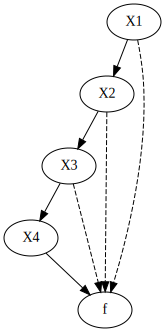

In [169]:
dot = Digraph()
dot.node('1', 'X1')
dot.node('2', 'X2')
dot.node('3', 'X3')
dot.node('4', 'X4')
dot.node('5', 'f')

dot.edges(['12','23', '34', '45'])
dot.edge('1', '5', style='dashed')
dot.edge('2', '5', style='dashed')
dot.edge('3', '5', style='dashed')

dot

In [176]:
n = 1000
x1 = np.random.randn(n)
x4 = x3 = x2 = x1
 
X = pd.DataFrame.from_dict({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4}).loc[:, ['X1', 'X2', 'X3', 'X4']]
f = lambda x: x[:, 3] # assume x 2d
f_d = pd.DataFrame.from_dict({'f': list(f(np.array(X)))})
pd.concat((X, f_d), 1)

,X1,X2,X3,X4,f
0,-0.839033,-0.839033,-0.839033,-0.839033,-0.839033
1,-1.311785,-1.311785,-1.311785,-1.311785,-1.311785
2,0.880421,0.880421,0.880421,0.880421,0.880421
3,-0.364005,-0.364005,-0.364005,-0.364005,-0.364005
4,0.374187,0.374187,0.374187,0.374187,0.374187
...,...,...,...,...,...
995,0.533592,0.533592,0.533592,0.533592,0.533592
996,1.089814,1.089814,1.089814,1.089814,1.089814
997,-0.043907,-0.043907,-0.043907,-0.043907,-0.043907
998,0.666706,0.666706,0.666706,0.666706,0.666706


In [191]:
n_explain = 10
explainer = OnManifoldExplainer(f, X, nruns=100, sigma_sq=0.1) 
cf_on_manifold = explainer.shap_values(X[:n_explain])

100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


In [186]:
explainer = IndExplainer(f, X, nruns=100)
cf_ind = explainer.shap_values(X[:n_explain])

[-0.83903314 -0.83903314 -0.83903314 -0.83903314 -0.83903314 -0.83903314
 -0.83903314 -0.83903314 -0.83903314 -0.83903314]


In [197]:
n_explain = 10
explainer = OnManifoldExplainer(f, X, nruns=100, sigma_sq=0.1, orderings=[[0, 1, 2, 3]])
cf_asv = explainer.shap_values(X[:n_explain])

100%|██████████| 10/10 [00:01<00:00,  6.11it/s]


In [182]:
causal_links = CausalLinks()
categorical_feature_names = ['Race', 'Sex']
target_name = 'f'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, lambda *args: f(np.vstack(args).T))
causal_links.add_causes_effects('X1', 'X2', lambda x: x)
causal_links.add_causes_effects('X2', 'X3', lambda x: x)
causal_links.add_causes_effects('X3', 'X4', lambda x: x)
causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, target_name=target_name)

cf_flow = GraphExplainer(causal_graph, X, nruns=100).shap_values(X[:100])

0it [00:00, ?it/s]
bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 2038.47it/s]


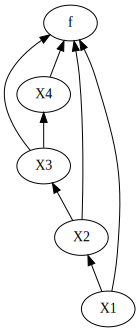

In [180]:
causal_graph.draw()

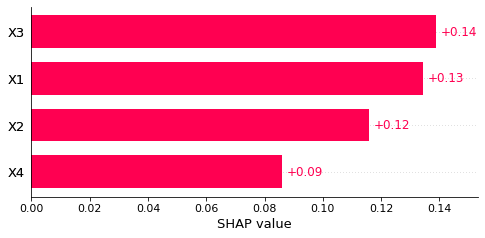

In [198]:
sample_ind = 3
cf_on_manifold.draw(sample_ind)

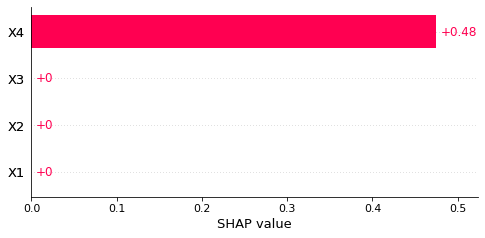

In [199]:
cf_ind.draw(sample_ind)

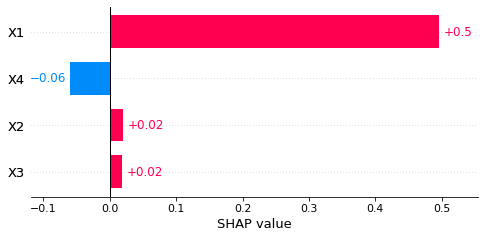

In [200]:
cf_asv.draw(sample_ind)

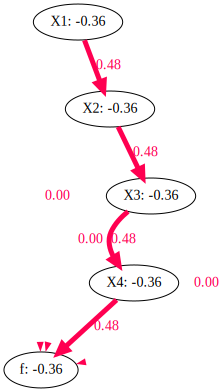

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f1b14e2d450>>

In [183]:
cf_flow.draw(sample_ind)

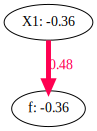

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f1b0b7625a0>>

In [190]:
cf_flow.draw_asv(sample_ind)

In [185]:
fg = X.iloc[sample_ind]
bg = X.iloc[0]
fg - bg

X1    0.475028
X2    0.475028
X3    0.475028
X4    0.475028
dtype: float64

# Simple experiment with correlation

In [138]:
n = 1000
x1 = np.random.randn(n)
x4 = x3 = x2 = x1
# x3 = np.random.randn(n)
# x4 = x3
 
# X = pd.DataFrame.from_dict({'X1': [1,2,3], 'X2': [1,2,3], 'X3':[4,5,6], 'X4':[4,5,6]})
X = pd.DataFrame.from_dict({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4})
f = lambda x: x[:, 0] + x[:, 1] # assume x 2d
f_d = pd.DataFrame.from_dict({'f': list(f(np.array(X)))})
pd.concat((X, f_d), 1)

,X1,X2,X3,X4,f
0,-1.654963,-1.654963,-1.654963,-1.654963,-3.309926
1,-0.614595,-0.614595,-0.614595,-0.614595,-1.229190
2,-0.602321,-0.602321,-0.602321,-0.602321,-1.204642
3,0.755364,0.755364,0.755364,0.755364,1.510728
4,-1.161839,-1.161839,-1.161839,-1.161839,-2.323678
...,...,...,...,...,...
995,-1.518999,-1.518999,-1.518999,-1.518999,-3.037998
996,-0.190871,-0.190871,-0.190871,-0.190871,-0.381743
997,-1.950839,-1.950839,-1.950839,-1.950839,-3.901677
998,-0.024424,-0.024424,-0.024424,-0.024424,-0.048848


In [161]:
n_explain = 10
explainer = OnManifoldExplainer(f, X, nruns=100, sigma_sq=1e-10) # smaller sigma, the more strict the matching
fa = explainer.shap_values(X[:n_explain])

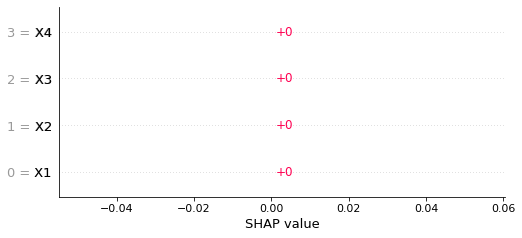

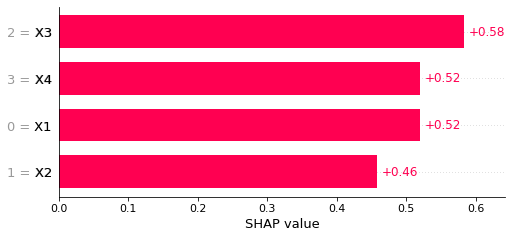

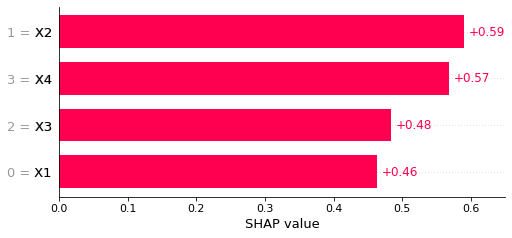

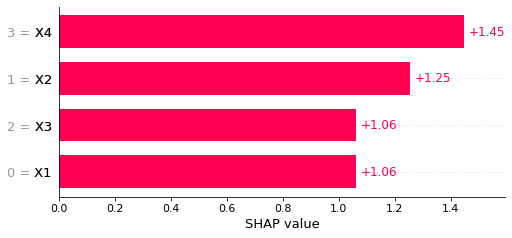

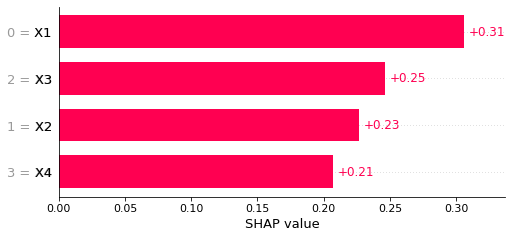

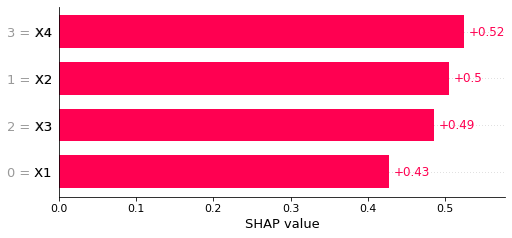

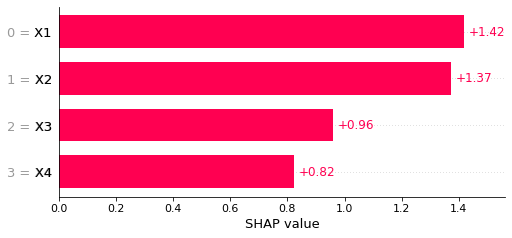

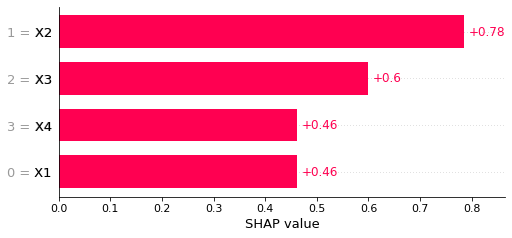

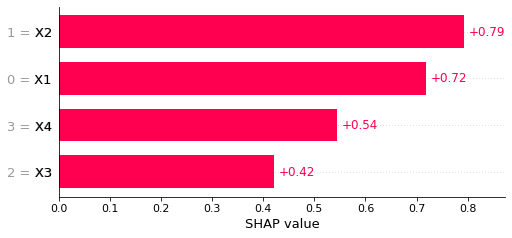

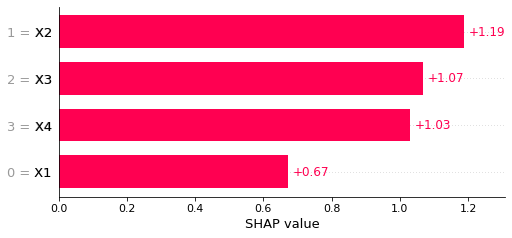

In [162]:
for i in range(len(X[:n_explain])):
    fa.draw(i)

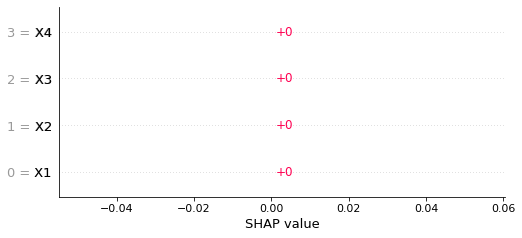

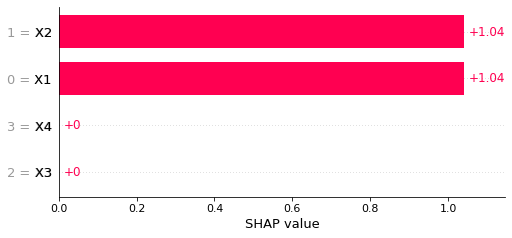

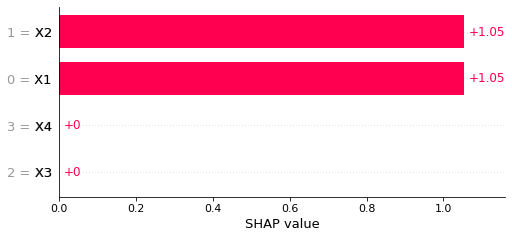

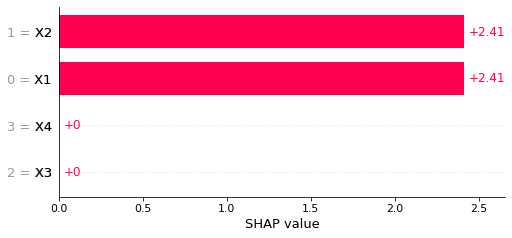

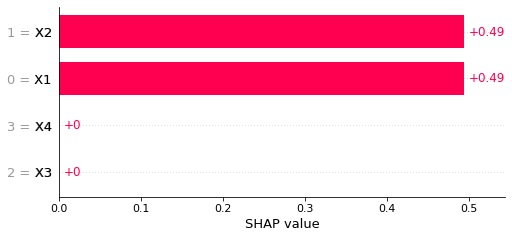

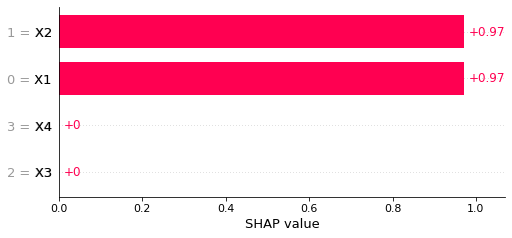

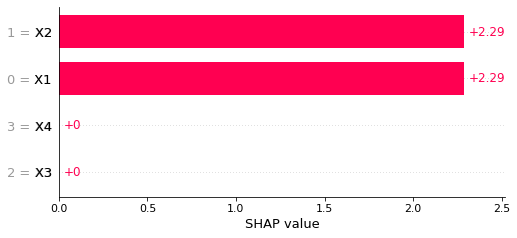

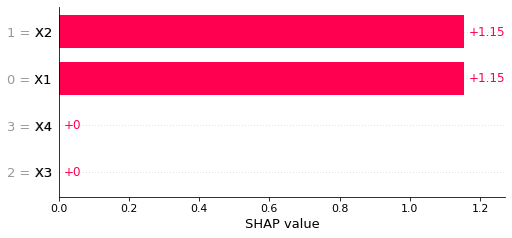

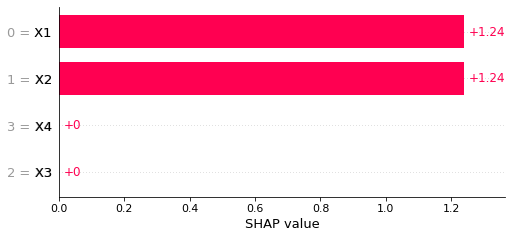

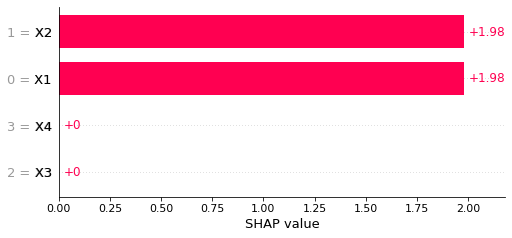

In [142]:
n_explain = 10
explainer = IndExplainer(f, X, nruns=100)
fa = explainer.shap_values(X[:n_explain])

for i in range(len(X[:n_explain])):
    fa.draw(i)